In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Developed for Google LLC by RedCastle Resources Inc
# https://www.redcastleresources.com/

# <img width=50px  src = 'https://apps.fs.usda.gov/lcms-viewer/images/lcms-icon.png'> Lab 8: Export and Post-processing

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/8-Export_and_Post_Processing.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/8-Export_and_Post_Processing.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/8-Export_and_Post_Processing.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>


## 8.0: Overview and Introduction


This notebook teaches how to export data from GEE into a final platform-agnostic image format.

While GEE is very powerful, outputs are often needed for use outside GEE. This notebook demonstrates the complete workflow LCMS uses to take GEE assets and make CogTiffs that can easily be used in practically any GIS/data analysis environment.


### 8.0.1: Objective

In this tutorial, you learn how to export the final thematic LCMS outputs to local CogTiffs, set custom no data values, update the names, and color map.

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`
- `Google Cloud Storage`

The steps performed include:

- Exporting assets to Google Cloud Storage
- Copying from Google Cloud Storage to a local directory
- Post-processing: Mosaicking and updating output color map and names
- Ensuring final output is a working CogTiff
- Viewing final CogTiffs using PIL and GEE

### 8.0.2: Before you begin

#### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

#### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/newFolder`
* This folder does not have to already exist. If it does not exist, it will be created

**If you are working in Qwiklabs and wish to export:** Copy the project ID from the 'Start Lab' screen into the `projectID` field in `export_path_root`.

In [6]:
workbench_url = 'https://185d94da42b13366-dot-us-central1.notebooks.googleusercontent.com/'
pre_baked_path_root  = 'projects/rcr-gee/assets/lcms-training'
export_path_root = pre_baked_path_root

print('Done')

Done


#### Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing the `raster_processing_lib` that relies on GDAL. The installation process for GDAL in Python can be cumbersome in some environments. We have provided guidance where possible.

In [8]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml

import os,secrets,glob,sys,platform,shutil
from PIL import Image
import matplotlib.pyplot as plt


ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1238


# Set up GDAL
# If using Windows, install from here: https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal
# If using Colab, GDAL should already be installed

# Use below to install GDAL in Workbench
try:
    import lcms_scripts.raster_processing_lib as rpl
except Exception as e:
    if getImagesLib.IS_WORKBENCH:
        print('GDAL is not installed. Will try to install')
        !sudo apt-get -y install libgdal-dev
        !gdal-config --version
        !pip install pygdal==3.2.2.10
        import lcms_scripts.raster_processing_lib as rpl
    elif platform.system() == 'Windows':
        print(e)
        print('GDAL is not installed and you are not using Workbench.')
        print('Easiest install method for GDAL on Windows is to install the correct whl for your Python version and 32 or 64 bit from here:')
        print('https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal')
        print(f'Your Python version is: {sys.version_info[0]}.{sys.version_info[1]}')
    else:
        print(e)
        print('GDAL is not installed and you are not using Workbench or Windows.')

print('Done')

Done


#### Set up your work environment

* Specify the assembled imageCollection from module 6
* Buckets containing both the temp and final outputs are available for use
* It is advised you use the pre-baked temp bucket to avoid waiting for re-exporting from GEE to Google Cloud Storage (GCS)
* Making your own final outputs does not take long, so specify a unique bucket name for final outputs
* Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab in geeViz.

**Warning!!**

* **Read-only access is provided for all authenticated  users for pre-baked outputs - including pre-baked Cloud Storage buckets**
* **If you are using the pre-baked output location (`export_path_root = pre_baked_path_root`,`temp_output_bucket = pre_baked_temp_output_bucket`,`final_output_bucket =  pre_baked_final_output_bucket`), you will see errors for any operation that tries to write, delete, or change access permissions to any object in the pre-baked output location.**
* **This is expected and will not stop you from successfully running this notebook - ignore these error messages should they appear.**


In [13]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_assembledLCMSOutputs_collection = f'{export_path_root}/lcms-training_module-6_assembledLCMSOutputs'

token = secrets.token_hex(8)

# Make unique bucket names for temp and final outputs
# Pre baked buckets have outputs already created
# Use these for skipping waiting for processing or make your own unique bucket names to run this for yourself
# While it is advised you used the pre_baked_temp_output_bucket, the final outputs are created quickly
pre_baked_temp_output_bucket = f'gs://lcms-training-outputs-temp'
pre_baked_final_output_bucket = f'gs://lcms-training-outputs-final'

temp_output_bucket = pre_baked_temp_output_bucket
final_output_bucket =  pre_baked_final_output_bucket

# You may need to run these functions if running outside Workbench
# In order to avoid permissions issues, ensure the projectName is the same as the one you used for authenticating 
# to GEE
# !gcloud auth login
# !gcloud projects list
# !gcloud config set project projectName

!gsutil mb {temp_output_bucket}
!gsutil mb {final_output_bucket}
local_processing_folder = '/tmp/lcms-training/local_processing'
rpl.check_dir(local_processing_folder)

print('Done')

Creating gs://lcms-training-outputs-temp/...
ServiceException: 409 A Cloud Storage bucket named 'lcms-training-outputs-temp' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


Done


Creating gs://lcms-training-outputs-final/...
ServiceException: 409 A Cloud Storage bucket named 'lcms-training-outputs-final' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [14]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1238
Map.proxy_url = workbench_url

print('Done')

Done


## 8.1: Set up inputs and processing environment
### 8.1.1: Bring in Assembled LCMS Outputs and visualize


In [11]:
Map.clearMap()
# Bring in assembled LCMS asset
lcms = ee.ImageCollection(export_assembledLCMSOutputs_collection)

# Add the assembled outputs to the map and take a look
Map.addLayer(lcms,{'min':1,'max':5},'Assembled LCMS')
Map.centerObject(lcms, 9)
Map.turnOnInspector()
Map.view()


Adding layer: Assembled LCMS
Starting webmap
Using default refresh token for geeView: C:\Users\ihousman/.config/earthengine/credentials
Local web server at: http://localhost:1238/geeView/ already serving.
cwd z:\Projects\06_LCMS_4_NFS\Scripts\lcms-training


### 8.1.2: Export Assembled LCMS Outputs to Google Cloud Storage

* These assets may be all you need. In their current format, they are very flexible for use in subsequent analyses within GEE. Often, you will have project needs outside GEE though. The next steps will demonstrate how to export the assets to a Google Cloud Storage bucket.

In [16]:
# Get info for exporting

# Pull the projection info from the assembled asset
projection = lcms.first().projection().getInfo()
if 'crs' in projection.keys():
    crs = projection['crs']
else:
    crs = projection['wkt']
transform = projection['transform']
scale=None


# Get studyArea 
study_area = lcms.first().geometry().bounds(500,crs)

# Find the years
years = [int(float(yr)) for yr in lcms.aggregate_histogram('year').keys().getInfo()]

# Find the products
products = lcms.first().bandNames().slice(0,3).getInfo()

# Set null value
nodata_value = 0

# Get the study area name
study_area_name = lcms.first().get('study_area').getInfo()

# Set version number
version = 'v2022-Training'

print('Done')

Done


In [17]:
# Iterate across each product and year and export to cloud storage
# This will take some time to complete
for product in products:
    lcms_class = lcms.select([product])
    
    for year in years:
        lcms_class_yr = lcms_class.filter(ee.Filter.calendarRange(year,year,'year')).first()
        
        output_name = f'LCMS_{study_area_name}_{version}_{product}_Annual_{year}'
        
        getImagesLib.exportToCloudStorageWrapper(lcms_class_yr,output_name,os.path.basename(temp_output_bucket),study_area,scale,crs,transform,outputNoData = nodata_value)


Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1985
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Training_Change_Annual_1985 (State.UNSUBMITTED)>
Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1986
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Training_Change_Annual_1986 (State.UNSUBMITTED)>
Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1987
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Training_Change_Annual_1987 (State.UNSUBMITTED)>
Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1988
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Training_Change_Annual_1988 (State.UNSUBMITTED)>
Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1989
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Training_Change_Annual_1989 (State.UNSUBMITTED)>
Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1990
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Training_Change_Annual_1990 (State.UNSUBMITTED)>
Exporting: LCMS_PRUSVI_v2022-Training_Change_Annual_1991
<Task Type.EXPORT_IMAGE: LCMS_PRUSVI_v2022-Traini

In [18]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the bucket of all images
# !gsutil -m rm {export_bucket}*.tif

print('done')

0 tasks ready 2023-12-12 10:46:20
0 tasks running 2023-12-12 10:46:20
Running names:


done


### 8.1.3: Copy to local folder for post-processing
* Look at what is in the bucket
* By default, GEE exports CogTiffs to the bucket
* These images have no color map, names, custom no data values, etc set.
* We will now copy to local folder for post-processing

In [19]:
# First open this link to view the outputs
print(f'https://console.cloud.google.com/storage/browser/{os.path.basename(temp_output_bucket)}')

https://console.cloud.google.com/storage/browser/lcms-training-outputs-temp


In [20]:
# Copy to local folder and make sure it worked
local_raw_exports_folder = os.path.join(local_processing_folder,'raw_exports')
rpl.check_dir(local_raw_exports_folder)
!gsutil -m cp {temp_output_bucket}/*.tif {local_raw_exports_folder}

print(os.listdir(local_raw_exports_folder))

('Making dir:', '/tmp/lcms-training/local_processing\\raw_exports')
['LCMS_PRUSVI_v2022-Training_Change_Annual_1985.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1986.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1987.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1988.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1989.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1990.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1991.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1992.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1993.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1994.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1995.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1996.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1997.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1998.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_1999.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_2000.tif', 'LCMS_PRUSVI_v2022-Training_Change_Annual_2001.tif', 'LCMS_PRUSVI_v2022-Training_Ch

Copying gs://lcms-training-outputs-temp/LCMS_PRUSVI_v2022-Training_Change_Annual_1985.tif...
/ [0/114 files][    0.0 B/152.5 MiB]   0% Done                                  
Copying gs://lcms-training-outputs-temp/LCMS_PRUSVI_v2022-Training_Change_Annual_1987.tif...
/ [0/114 files][    0.0 B/152.5 MiB]   0% Done                                  
Copying gs://lcms-training-outputs-temp/LCMS_PRUSVI_v2022-Training_Change_Annual_1986.tif...
Copying gs://lcms-training-outputs-temp/LCMS_PRUSVI_v2022-Training_Change_Annual_1989.tif...
/ [0/114 files][    0.0 B/152.5 MiB]   0% Done                                  
/ [0/114 files][    0.0 B/152.5 MiB]   0% Done                                  
Copying gs://lcms-training-outputs-temp/LCMS_PRUSVI_v2022-Training_Change_Annual_1988.tif...
Copying gs://lcms-training-outputs-temp/LCMS_PRUSVI_v2022-Training_Change_Annual_1992.tif...
/ [0/114 files][    0.0 B/152.5 MiB]   0% Done                                  
/ [0/114 files][    0.0 B/152.5 MiB] 

## 8.2 Post Processing and Export

### 8.2.1: Create VRTs
* VRT = Virtual Raster Template 
* Sometimes if the raster is very large, GEE will break an individual image into tiled outputs
* We will need to ensure those get mosaicked back together 
* We will look for sets of images with the same name
* Note that for the default test study area of Puerto Rico and the US Virgin Islands, the outputs are not broken into tiles

In [22]:
# Find sets of images
local_post_processing_folder = os.path.join(local_processing_folder,'Post_Processing')
# shutil.rmtree(local_post_processing_folder)
# rpl.check_dir(local_raw_exports_folder)
rpl.check_dir(local_post_processing_folder)
for product in products:
    for year in years:
        # print(product,year)
        tiles = glob.glob(os.path.join(local_raw_exports_folder,f'LCMS*{product}*_Annual_{year}.tif'))
        bn = rpl.base(tiles[0])
        out_vrt = bn.split('{}_Annual_{}'.format(product,year))[0]+'{}_Annual_{}.vrt'.format(product,year)
        
        
        vrt_image = os.path.join(local_post_processing_folder,out_vrt)
        if not os.path.exists(vrt_image):
            rpl.buildVRT(tiles,vrt_image)
        else:
            print('Already created:',out_vrt)
print(len(os.listdir(local_post_processing_folder)))

('Making dir:', '/tmp/lcms-training/local_processing\\Post_Processing')
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Building VRT
Build

### 8.2.2 Set Colors

* All thematic LCMS outputs have a default color map and names applied
* We will pull the values in from GEE to then be set in the local tifs


In [23]:
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2022-8").filter('study_area=="PRUSVI"').first().toDictionary().getInfo()

color_names_dict = {}

for product in products:
    colors = lcms_viz_dict[f'{product}_class_palette'].copy()
    colors = [f'#{c}' for c in colors]
    colors.insert(0,'#000000')
    
    names = lcms_viz_dict[f'{product}_class_names'].copy()
    names.insert(0,'')
    
    ct = rpl.get_ct(colors)
    
    color_names_dict[product] = {'ct':ct,'names':names}

print('Done')

Done


In [24]:
vrts = glob.glob(os.path.join(local_post_processing_folder,'*.vrt'))
version = 'v2022-Training'
for vrt in vrts:
    product = rpl.base(vrt)
    product = product.split(version+'_')[1].split('_Annual_')[0]
   
    rpl.update_color_table_or_names(vrt,color_table =color_names_dict[product]['ct'],names = color_names_dict[product]['names'])
        

('Updating color table for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1985.vrt')
('Updating names for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1985.vrt')
('Updating color table for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1986.vrt')
('Updating names for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1986.vrt')
('Updating color table for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1987.vrt')
('Updating names for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1987.vrt')
('Updating color table for:', '/tmp/lcms-training/local_processing\\Post_Processing\\LCMS_PRUSVI_v2022-Training_Change_Annual_1988.vrt')
('Updating names for:', '/tmp/lcms-training/local_processin

### 8.2.3 Convert to COG and Perform Final Post Processing

* We will now:
    * Set no data
    * Ensure the projection is set properly
    * Update summary statistics
    * Compute pyramids
    * Recreate COG after breaking it (this also converts VRT to mosaicked COGTiff)
    * Validate it is a valid COG
    
We're using this function in the lcms_scripts raster processing library (rpl): [update_cog](https://github.com/redcastle-resources/lcms-training/blob/69c7c3c969ba17e34b7e6b409e10fee7e42f1969/lcms_scripts/raster_processing_lib.py#L28).


In [25]:
# This can take a few minutes to complete

# get crs
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']

# list vrts
vrts = glob.glob(os.path.join(local_post_processing_folder,'*.vrt'))

# use function to update cog
for vrt in vrts:
    rpl.update_cog(vrt,crs,
                   no_data_value = 0, 
                   update_stats = True, 
                   stat_stretch_type = None,
                   pyramid_reducer = 'MODE',
                   bigtiff='YES')

print('Done')

Updating crs and no data and preserving COG layout for:  /tmp/lcms-training/local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1985.vrt
out_image_name /tmp/lcms-training/local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1985.tif
('Min:', 1.0)
('Max:', 5.0)
('Mean:', 1.5692820910821044)
('Std:', 1.2884048115034166)
/tmp/lcms-training/local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1985.tif is a valid cloud optimized GeoTIFF

The size of all IFD headers is 28914 bytes
/tmp/lcms-training/local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1985.tif is a valid COGTiff:  True
Updating crs and no data and preserving COG layout for:  /tmp/lcms-training/local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1986.vrt
out_image_name /tmp/lcms-training/local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1986.tif
('Min:', 1.0)
('Max:', 5.0)
('Mean:', 1.259707253761

### 8.2.4 Move and View final LCMS outputs

* Move outputs back to Google Cloud Storage so we can move them wherever we will need the outputs (local, GEE, AWS, etc...)

* As an example of where you can take the data from Google Cloud Storage, we will then view the final cogTiffs in:
    * PyPlot
    * Bring them back into GEE
     


In [26]:
# Copy cogTif and xml (color table) to GCS
!gsutil -m cp {local_post_processing_folder}/*.tif {final_output_bucket}
!gsutil -m cp {local_post_processing_folder}/*.tif.aux.xml {final_output_bucket}


Copying file://\tmp\lcms-training\local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1989.tif [Content-Type=image/tiff]...
/ [0/114 files][    0.0 B/175.4 MiB]   0% Done                                  
Copying file://\tmp\lcms-training\local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1995.tif [Content-Type=image/tiff]...
/ [0/114 files][    0.0 B/175.4 MiB]   0% Done                                  
Copying file://\tmp\lcms-training\local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_1993.tif [Content-Type=image/tiff]...
/ [0/114 files][    0.0 B/175.4 MiB]   0% Done                                  
Copying file://\tmp\lcms-training\local_processing\Post_Processing\LCMS_PRUSVI_v2022-Training_Change_Annual_2006.tif [Content-Type=image/tiff]...
/ [0/114 files][    0.0 B/175.4 MiB]   0% Done                                  
Copying file://\tmp\lcms-training\local_processing\Post_Processing\LCMS_PRUSVI_v2022-Trainin

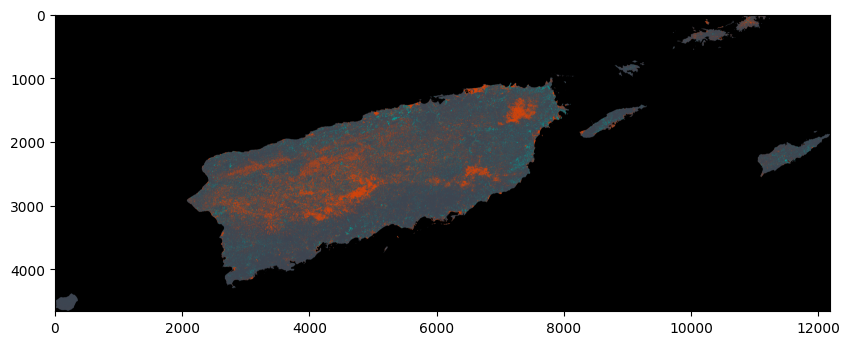

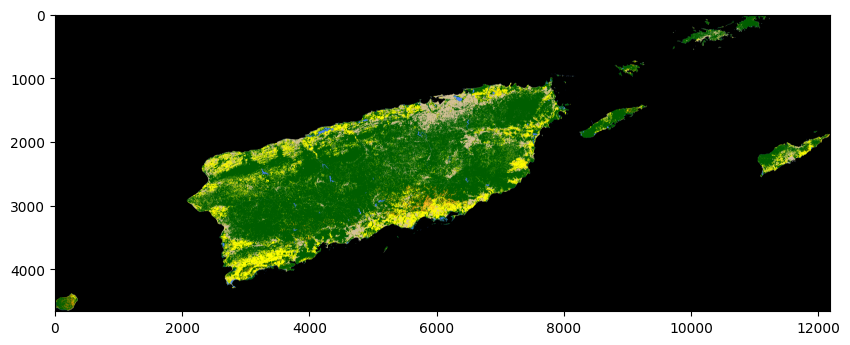

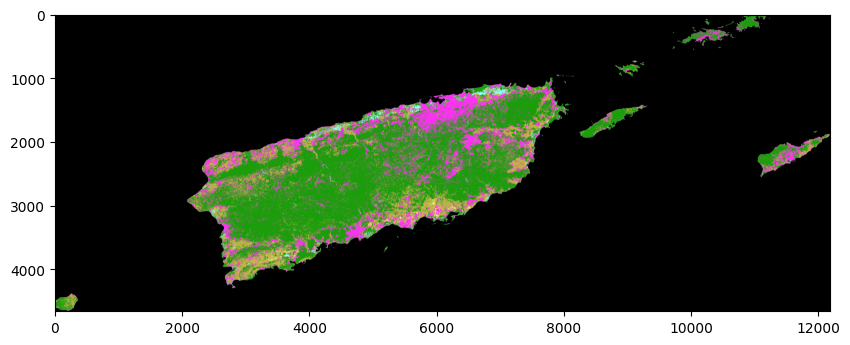

In [27]:
# Now, let's view them as an image
year = 2017
for product in products:
    cog = glob.glob(os.path.join(local_post_processing_folder,f'*{product}*{year}*.tif'))[0]
    im = Image.open(cog, 'r')
    plt.figure(figsize=(10,6))
    plt.imshow(im)
    
    del im

In [28]:
# Open this link to view the final outputs
print(f'https://console.cloud.google.com/storage/browser/{os.path.basename(final_output_bucket)}')

https://console.cloud.google.com/storage/browser/lcms-training-outputs-final


In [29]:
# Next, we'll bring the same images into GEE
# You may need to make the final_output_bucket public
Map.clearMap()
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2022-8").filter('study_area=="PRUSVI"').first().toDictionary().getInfo()

year = 2017
for product in products:
    cog = glob.glob(os.path.join(local_post_processing_folder,f'*{product}*{year}*.tif'))[0]
    
    uri = f'{final_output_bucket}/{os.path.basename(cog)}'
    print(uri)
    img = ee.Image.loadGeoTIFF(uri).rename([product]).set(lcms_viz_dict)
    Map.addLayer(img,{'autoViz':True},f'LCMS {product} {year}')

Map.turnOnInspector()
Map.view()

gs://lcms-training-outputs-final/LCMS_PRUSVI_v2022-Training_Change_Annual_2017.tif
Adding layer: LCMS Change 2017
gs://lcms-training-outputs-final/LCMS_PRUSVI_v2022-Training_Land_Cover_Annual_2017.tif
Adding layer: LCMS Land_Cover 2017
gs://lcms-training-outputs-final/LCMS_PRUSVI_v2022-Training_Land_Use_Annual_2017.tif
Adding layer: LCMS Land_Use 2017
Starting webmap
Using default refresh token for geeView: C:\Users\ihousman/.config/earthengine/credentials
Local web server at: http://localhost:1238/geeView/ already serving.
cwd z:\Projects\06_LCMS_4_NFS\Scripts\lcms-training


## Lab 8 challenge:

**If you are accessing this lab through Qwiklabs, this challenge will be assessed for completion in Lab 8. Make sure the path to your output image exactly matches the path below.**
1. Create a copy of the Change output for 2017

     ```python
        input_image = "/tmp/lcms-training/local_processing/Post_Processing/LCMS_PRUSVI_v2022-Training_Change_Annual_2017.tif"
        output_image = "/tmp/challenge/LCMS_PRUSVI_v2022-Training_Change_Annual_2017_Challenge_Answer.tif"


        if not os.path.exists(os.path.dirname(output_image)):os.makedirs(os.path.dirname(output_image))
        
        shutil.copy(input_image,output_image)

    ```
    
<br>

2. Colors and class labels are difficult to choose. Choose a different color palette and use different names for the Change output and apply it to the copy of the output for 2017

    * The default colors for Change are: `['#000000', '#3d4551', '#f39268', '#d54309', '#00a398', '#1b1716']`
    
    * Change the colors to any new color set. 

    * The default names are: `['', 'Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask']`
    
    * Change the names to the following: names = `['', 'No Change', 'Insects and Disease', 'Fire Harvest and Other', 'Regrowth', 'Non-Processing Area Mask']`
    
    * Some good color palette making resources are: 
        * [Paletton](https://paletton.com/)
        * [EE Palettes](https://github.com/gee-community/ee-palettes)
        * [Color Brewer 2](https://colorbrewer2.org/)
    
    
    * Adapt the methods from section 8.3.1 to apply your colors to the copy

    <br> 
3. Check that the output xml exists (this is automatically created when the names are updated).
    * Example: 
    ```python
        print(os.path.exists(output_image+'.aux.xml'))
    ```
<br>


In [19]:
# insert challenge code here


## Done with Module 8